# Exercise 6.3: Nonlinear fitting of the resonant scattering of neutron from a nucleus. 

Perform a $\chi^2$ fit of the neutron scattering data using the equations obtained through the minimization of $\chi^2$. Assume that the absolute error ($\sigma_i$) is equal for all data points and find a reasonable estimate for its magnitude. 

Use the following data:

| Energy (MeV) | Cross Section (mb)| 
| ------------ | ----------------- |
| 0 | 10.6 | 
| 25 | 16.0 | 
| 50 | 45.0 |
| 75 | 83.5 | 
| 100 | 52.8 | 
| 125 | 19.9 | 
| 150 | 10.8 | 
| 175 | 8.25 | 
| 200 | 4.7 | 

and the theoretical function $f(E) = \frac{ f_r } { (E-E_r)^2 + \Gamma^2/4 }$.

For initial guesses, look at the plot and consider that: 

At the peak, $f = a_1 / a_3$, $a_3 = \Gamma_2^2 / 4$, where $\Gamma$ is the full-width of the peak at half-maximum and $x = a_2$ is the position of the peak.

BONUS 10%: Use SciPy's ```optimize.curve_fit``` to do the fit. Compare SciPy's results to the ones you obtained. See https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

Solution:

Let's first write down the data. We will then need to construct the functions. 

The necessary derivatives have already been given to us, so it's only a matter of looping over the data.

The $N_P$ equations:

$\sum_{i=1}^{N_D} \frac{ [y_i - g(x_i; \{a_n\})] } { \sigma_i^2 } \frac{ \partial g(x_i; \{a_n\}) }{ \partial a_m }  = 0$, $m=1,...,N_P$. 

For the sake of simplicity, let's rewrite the theory function using the redefinitions:

$f_r \rightarrow a_1$, $E_r \rightarrow a_2$, $\Gamma^2/4 \rightarrow a_3$, $E\rightarrow x$ such that:

$g(x; a_1, a_2, a_3) = \frac{ a_1 } { (x-a_2)^2 + a_3 }$.

The derivatives required are then:

$\frac{ \partial g } { \partial a_1 } = \frac{ 1 } { (x-a_2)^2 + a_3 }$, $\frac{ \partial g } { \partial a_2 } = \frac{ -2 a_1 (x - a_2) }{[ (x-a_2)^2 + a_3]}$, $\frac{ \partial g } { \partial a_3 } =  \frac{ -a_1 } { [ (x-a_2)^2 + a_3]^2}$. 

In [2]:
# Copying over the necessary functions from our N-Dimensional Newton-Raphson method:
import numpy as np
from numpy import linalg 

# modify from Chapter 4: 
# define a function for the central-difference derivative.
# x is now a NumPy array
# i is the component of the function (f_i) to be differentiated
# j is the component of the vector x to differentiate by (x_j)
def dfdt_CD_ND(func, i, j, x, h): 
    """Calculates the central-difference partial derivative of a function func at vector x, in the j-th direction, with step size dx"""
    N = len(x) # get the length of the input array
    # increement only the j-th element by an amount dx
    dx = np.zeros(N) 
    dx[j] = h 
    return (np.array(func(x+dx/2)[i]) - np.array(func(x-dx/2)[i]))/h

# A higher-order function that calculates the Jacobian matrix for the N-dimensional vector of functions f_i:
# we will use a central-difference approximation to the derivatives, and a parameter h = 1E-5 for all directions 
def Jacobian(funcvector, x, h): # the input should be a NumPy array of functions, each of which is a function of N variables (x_i)
    """Calculate the Jacobian of the function vector as an NxN matrix using the central-difference approximation to the derivatives"""
    N = len(funcvector(x)) # get the number of dimensions
    output = np.zeros((N,N)) #  the output is an NxN NumPy array
    for i in range(N): # loop over the functions f_i
        for j in range(N): # loop over variables x_j:
            dfi_dxj = dfdt_CD_ND(funcvector, i,j,x,h)
            output[i][j] = dfi_dxj # set this to the correct element of the Jacobian   
    return output 

# The N-D Newton-Raphson algorithm: 
# x0 is the initial guess, it should have the same dimensions as the number of variables! 
# Nmax is the number of evaluations
# prec is the required precision
# dx is the distance over which to take the central-difference derivative (not the same as the step size!)
def NewtonRaphsonND(func, x0, Nmax, prec, h): 
    """Function that implements the N-Dimensional Newton-Raphson algorithm for root finding"""
    # perform check that the number of dimensions is the same for the function and variables
    N = len(func(x0)) # get the number of dimensions
    if N != len(x0):
         raise Exception("The length of the function vector is not the same as the number of unknowns")
    n = 0 # the number of steps taken
    val = 1E99*np.ones(N) # the value of the equations, initialize to a large number
    roots = np.nan*np.ones(N) # initialize the roots to "not a number"
    for nn in range(Nmax): # loop runs up to the max number of evals, or up to the point where the precision is reached
        # get the values of the function at x0:
        minus_f = -func(x0)
        # check whether the required precision has been reached for *each* value:
        if np.all(np.abs(minus_f) < prec):
            n = nn # save the number of steps taken 
            print('Newton-Raphson Precision reached! Exiting')
            break # exit the loop nn
        # Get the Jacobian (J):
        J = Jacobian(func, x0, h)
        # calculate the step vector Dx using linear algebra (see Chapter 6, "NumPy's linalg Package" section)
        Dx = linalg.solve(J, minus_f).reshape(N) # turn this into the right shape (column vector)
        # update the guess and the value of the equation:
        x0 = np.add(x0, Dx)
    roots = x0
    return roots, n

Essentially, all we now need is a function that spits out the nonlinear equations to be solved. 

In [3]:
# the theory function:
def g(x, a):
    """The Breit-Wigner in terms of a1, a2, a3"""
    return a[0]/((x-a[1])**2 + a[2])

# function that contains the non-linear equations that we need to solve,
# in the same format as fi_twomasses in Solution6.2.ipynb
# Instead of "x" we use "a" as the "vector" of unknowns, in this case a_1, a_2, a_3
def fi_chisqmin(a):
    """Function containing the chi-sq minimization conditions"""
    # the data: 
    xdata = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200])
    ydata = np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])
    # the functions to be returned:
    f1, f2, f3 = 0, 0, 0
    # loop over the data and sum:
    for i in range(len(xdata)):
        f1 = f1 + (ydata[i] - g(xdata[i], a)) / ( (xdata[i] - a[1])**2 + a[2] )
        f2 = f2 + (ydata[i] - g(xdata[i], a)) * (xdata[i] - a[1]) /( (xdata[i] - a[1])**2 + a[2] )**2
        f3 = f3 + (ydata[i] - g(xdata[i], a)) / ( (xdata[i] - a[1])**2 + a[2] )**2
    return np.array([f1, f2, f3])

In [4]:
import numpy as np
# Let's find the roots for a1, a2, a3:
Nmax = 1000
prec = 1E-6
h = 1E-5
aguess = np.array([40000, 75, 50**2/4])
roots, niterations = NewtonRaphsonND(fi_chisqmin, aguess, Nmax, prec, h)
print('The roots are a1, a2 a3=', roots, 'after', niterations, 'iterations')
print('The values of f_r, E_r and Gamma are=', roots[0]/roots[2], roots[1], 2*np.sqrt(roots[2]))

Newton-Raphson Precision reached! Exiting
The roots are a1, a2 a3= [66884.41393327    77.49358192   788.85039629] after 6 iterations
The values of f_r, E_r and Gamma are= 84.7871969737228 77.49358192109344 56.172961335243656


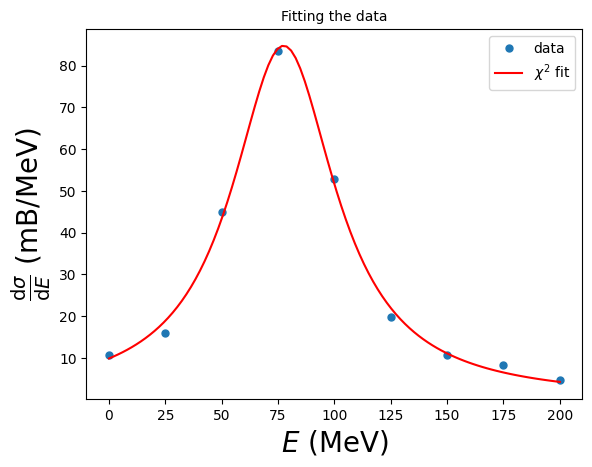

In [14]:
# plot the fit and data:
import matplotlib.pyplot as plt # import matplotlib, a conventional module name is plt
import numpy as np

fig, ax = plt.subplots() # create the elements required for matplotlib. This creates a figure containing a single axes.

# set the labels and titles:
ax.set_xlabel(r'$E$ (MeV)', fontsize=20) # set the x label
ax.set_ylabel(r'$\frac{\mathrm{d}\sigma}{\mathrm{d}E}$ (mB/MeV)', fontsize=20) # set the y label 
ax.set_title('Fitting the data', fontsize=10) # set the title 

# get the fit data:
xfit = np.linspace(0, 200, 100)
yfit = [g(x,roots) for x in xfit]
# the data:
xdata = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200])
ydata = np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])

# plot the data
ax.plot(xdata, ydata, label='data', lw=0,ms=5,marker='o') 
# plot the interpolations
ax.plot(xfit, yfit, label='$\chi^2$ fit', color='red') 


# construct the legend:
ax.legend(loc='upper right')  # Add a legend

plt.show() # show the plot here

Let's write a function for chisq given the parameters:

In [12]:
def chisq(a, sigma):
    """Function that calculates the actual chi-sq """
    # the data: 
    xdata = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200])
    ydata = np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])
    # the chisq:
    chisq = 0
    # loop over the data and sum:
    for i in range(len(xdata)):
        chisq += (ydata[i] - g(xdata[i], a))**2 / sigma**2
    return chisq

chisq_sigma1 = chisq(roots, 1)
print('error for sigma=1', chisq_sigma1)
# the chisq should be ~ ndof = 9 - 3 = 6
sigma_estimate = np.sqrt(chisq_sigma1/6)
print('error estimate=', sigma_estimate)
print('confirm that chisq ~ 6 for this:', chisq(roots, sigma_estimate))


error for sigma=1 21.065754296306597
error estimate= 1.8737553333838526
confirm that chisq ~ 6 for this: 6.0


Let's also use scipy's ```curve_fit``` to try and fit this!

In [52]:
from scipy.optimize import curve_fit

# the theory function:
def g2(x, a1, a2, a3):
    """The Breit-Wigner in terms of a1, a2, a3"""
    return a1/((x-a2)**2 + a3)

xdata = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200])
ydata = np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])

# solve!:
popt, pcov = curve_fit(g2, xdata, ydata)
print('SciPy a1, a2, a3=', popt)
# We can also get the errors through this!
print('Errors:', np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2]))
# and the full covariance matrix allows us to look at the correlations between parameters:
print(pcov)

SciPy a1, a2, a3= [66886.39636723    77.493579     788.88395655]
Errors: 3438.636109945428 0.726104132590368 49.77860417094824
[[ 1.18242183e+07 -2.85998171e+02  1.61981198e+05]
 [-2.85998171e+02  5.27227211e-01 -4.88183428e+00]
 [ 1.61981198e+05 -4.88183428e+00  2.47790943e+03]]
